In [240]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score, r2_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn import linear_model, discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")

In [241]:
df = pd.read_csv('Data/diabetes.csv')

In [242]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


In [243]:
df = pd.get_dummies(df, drop_first=True)
df

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,0,False,False,False,False,False,False,False
99996,2.0,0,0,17.37,0,False,False,False,False,False,False,False
99997,66.0,0,0,27.83,0,True,False,False,False,True,False,False
99998,24.0,0,0,35.42,0,False,False,False,False,False,True,False


In [244]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False)+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

In [245]:
target= 'diabetes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# KNN

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización de datos
    ('knn', KNeighborsClassifier())  
])

params_grid = {
    'knn__n_neighbors': range(1, 50), 
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'] 
}

random_seach = RandomizedSearchCV(estimator=pipeline, 
                                  param_distributions=params_grid, n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc')

random_seach.fit(X_train, y_train)


AUC 0.8199780617164899


In [247]:
random_seach.best_params_

{'knn__weights': 'uniform', 'knn__n_neighbors': 47, 'knn__metric': 'euclidean'}

In [248]:
random_knn = random_seach.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=random_knn, y_true=y_test))

AUC 0.8199780617164899


(array([12809.,  2649.,  1690.,  1120.,   536.,   697.,   289.,   131.,
           41.,    38.]),
 array([0.        , 0.06382979, 0.12765957, 0.19148936, 0.25531915,
        0.31914894, 0.38297872, 0.44680851, 0.5106383 , 0.57446809,
        0.63829787]),
 <BarContainer object of 10 artists>)

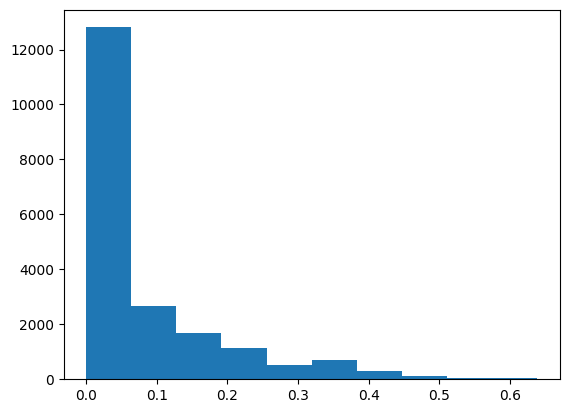

In [249]:
plt.hist(random_knn, bins=10)

# Regresion Logistica

In [250]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # grado se definirá en grid search
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, random_state=42))
])

params_grid = {
    'poly__degree':[1,2,3],
    'logreg__penalty':['l2', None],
    'logreg__C':[0.01, 0.1, 1]
}

In [251]:
log_reg_random = RandomizedSearchCV(estimator=pipeline, cv=5, n_jobs=-1,
                                    scoring='roc_auc',
                                    param_distributions=params_grid,
                                    n_iter=5)

log_reg_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(include_bias=False)),
                                             ('scaler', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'logreg__C': [0.01, 0.1, 1],
                                        'logreg__penalty': ['l2', None],
                                        'poly__degree': [1, 2, 3]},
                   scoring='roc_auc')

In [252]:
log_reg_random.best_params_

{'poly__degree': 2, 'logreg__penalty': None, 'logreg__C': 0.01}

In [253]:
probabilites_log_reg_random = log_reg_random.best_estimator_.predict_proba(X_test)[:,1]

print("AUC",roc_auc_score(y_score=probabilites_log_reg_random, y_true=y_test))

AUC 0.8401692381870781


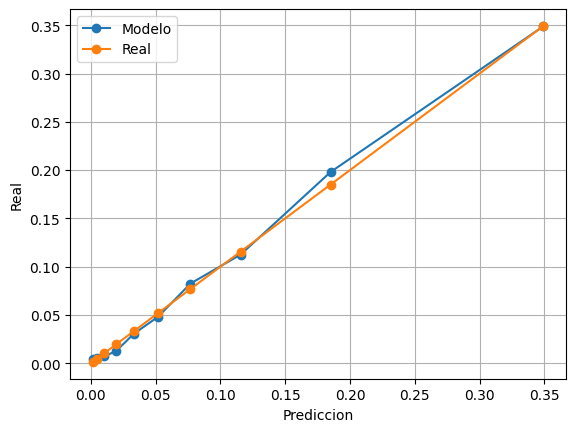

In [254]:
calibracion(probabilites_log_reg_random, y_test, 10)

(array([1.2995e+04, 3.2640e+03, 1.6380e+03, 9.4200e+02, 5.9200e+02,
        2.9000e+02, 1.7100e+02, 6.5000e+01, 3.2000e+01, 1.1000e+01]),
 array([1.09163317e-06, 7.67147700e-02, 1.53428448e-01, 2.30142127e-01,
        3.06855805e-01, 3.83569483e-01, 4.60283162e-01, 5.36996840e-01,
        6.13710518e-01, 6.90424197e-01, 7.67137875e-01]),
 <BarContainer object of 10 artists>)

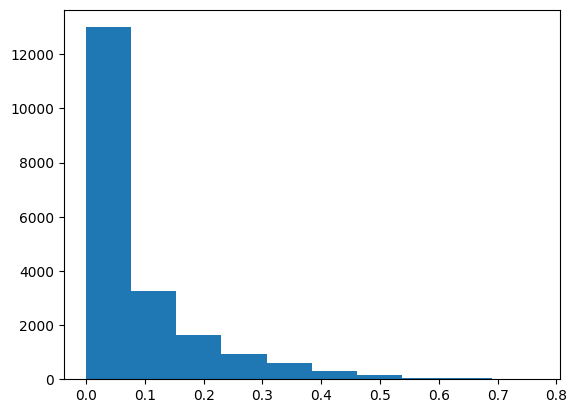

In [255]:
plt.hist(probabilites_log_reg_random, bins=10)

# Analisis del discriminante lineal

In [256]:
pipeline = Pipeline([
    ("scaler",  StandardScaler()),
    ("model", discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)

probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:, 1]
print("AUC", roc_auc_score(y_score=probabilidades_modelo_disc, y_true=y_test))

AUC 0.8307843137254902


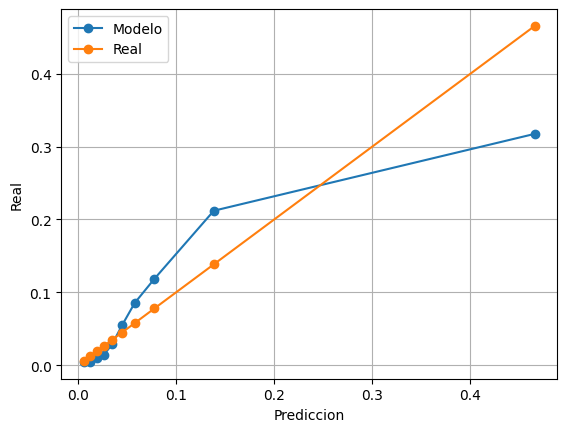

In [257]:
calibracion(probabilidades_modelo_disc, y_test, 10)

(array([16291.,  1445.,   540.,   537.,   490.,   282.,   162.,    72.,
           94.,    87.]),
 array([0.00235839, 0.09905791, 0.19575742, 0.29245693, 0.38915645,
        0.48585596, 0.58255548, 0.67925499, 0.7759545 , 0.87265402,
        0.96935353]),
 <BarContainer object of 10 artists>)

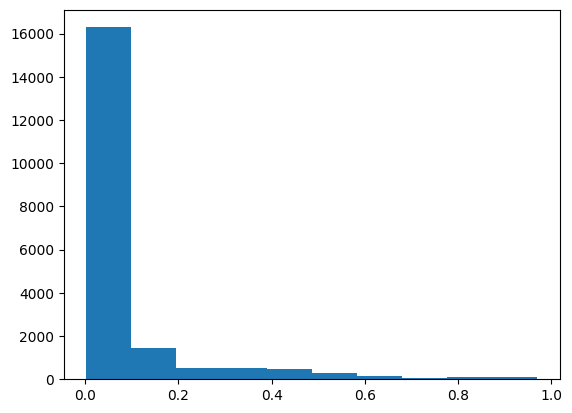

In [258]:
plt.hist(probabilidades_modelo_disc, bins=10)

# Red Neuronal

In [259]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(max_iter=1000, random_state=42))
])

# Params grid
params_grid = {
     'nn__hidden_layer_sizes': [(50,50,50), (10,), (100,), (10,10)],
     'nn__activation': ['tanh', 'relu', 'logistic'],
     'nn__alpha': [0.1, 0.01]
}

# Fit 
grid_nn = RandomizedSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_distributions=params_grid)

grid_nn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('nn',
                                              MLPClassifier(max_iter=1000,
                                                            random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'nn__activation': ['tanh', 'relu',
                                                           'logistic'],
                                        'nn__alpha': [0.1, 0.01],
                                        'nn__hidden_layer_sizes': [(50, 50, 50),
                                                                   (10,),
                                                                   (100,),
                                                                   (10, 10)]},
                   scoring='roc_auc')

In [260]:
grid_nn.best_params_

{'nn__hidden_layer_sizes': (10, 10),
 'nn__alpha': 0.1,
 'nn__activation': 'tanh'}

In [261]:
nn_predictions = grid_nn.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=nn_predictions, y_true=y_test))

AUC 0.8394162005785921


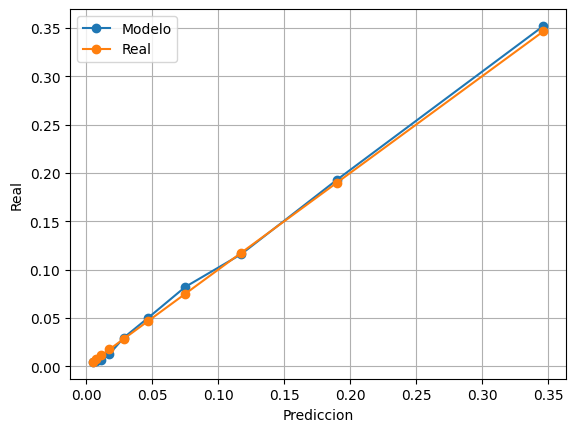

In [262]:
calibracion(nn_predictions, y_test, 10)

(array([1.3052e+04, 2.8980e+03, 1.6350e+03, 1.0450e+03, 6.4400e+02,
        3.8000e+02, 2.0600e+02, 9.3000e+01, 3.5000e+01, 1.2000e+01]),
 array([0.00335403, 0.0743648 , 0.14537556, 0.21638632, 0.28739709,
        0.35840785, 0.42941861, 0.50042938, 0.57144014, 0.6424509 ,
        0.71346167]),
 <BarContainer object of 10 artists>)

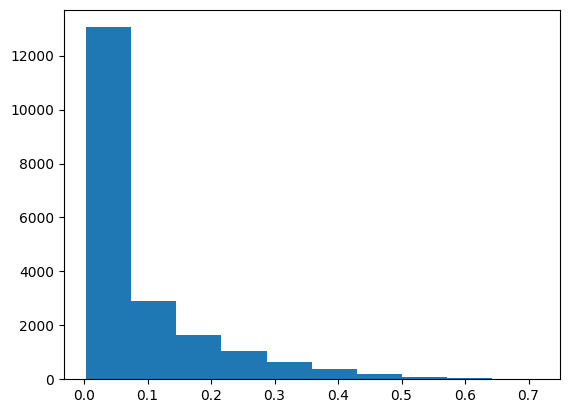

In [263]:
plt.hist(nn_predictions, bins=10)

# AUC modelos

In [264]:
auc = pd.DataFrame({
    'knn': [roc_auc_score(y_score=random_knn, y_true=y_test)],
    'Regresion Logistica': [roc_auc_score(y_score=probabilites_log_reg_random, y_true=y_test)],
    'Analisis del discriminante lineal': [roc_auc_score(y_score=probabilidades_modelo_disc, y_true=y_test)],
    'Red Neuronal': [roc_auc_score(y_score=nn_predictions, y_true=y_test)]
})
auc

,knn,Regresion Logistica,Analisis del discriminante lineal,Red Neuronal
0,0.819978,0.840169,0.830784,0.839416


In [265]:
df.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False


# Feature Engineering

In [266]:
df['age/bmi'] = df['age'] / df['bmi']
df['age*bmi'] = df['age'] * df['bmi']

df['age^2'] = df['age'] ** 2
df['bmi^2'] = df['bmi'] ** 2
df.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age/bmi,age*bmi,age^2,bmi^2
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False,3.175863,2015.20,6400.0,634.5361
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False,1.976574,1475.28,2916.0,746.3824
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False,1.024890,764.96,784.0,746.3824
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False,1.535181,844.20,1296.0,549.9025
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False,3.773585,1530.64,5776.0,405.6196


In [288]:
target= 'diabetes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# KNN Feature Eng

In [268]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización de datos
    ('knn', KNeighborsClassifier())  
])

params_grid = {
    'knn__n_neighbors': range(1, 50), 
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'] 
}

random_seach = RandomizedSearchCV(estimator=pipeline, 
                                  param_distributions=params_grid, n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc')

random_seach.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'knn__metric': ['euclidean',
                                                        'manhattan'],
                                        'knn__n_neighbors': range(1, 50),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='roc_auc')

In [269]:
random_seach.best_params_

{'knn__weights': 'uniform', 'knn__n_neighbors': 47, 'knn__metric': 'euclidean'}

In [270]:
random_knn_fe = random_seach.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=random_knn_fe, y_true=y_test))

AUC 0.8197333011893282


(array([12787.,  2729.,  1655.,  1116.,   714.,   488.,   282.,   139.,
           62.,    28.]),
 array([0.        , 0.06595745, 0.13191489, 0.19787234, 0.26382979,
        0.32978723, 0.39574468, 0.46170213, 0.52765957, 0.59361702,
        0.65957447]),
 <BarContainer object of 10 artists>)

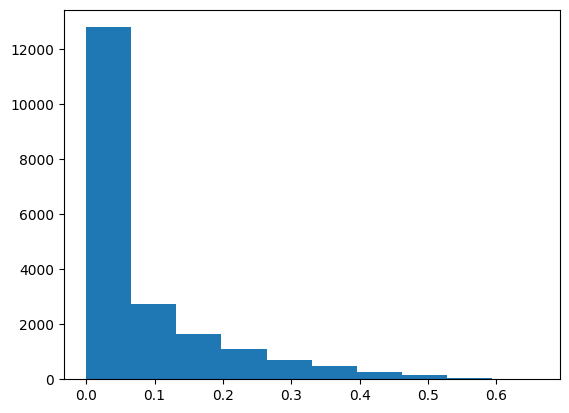

In [271]:
plt.hist(random_knn_fe, bins=10)

# Regresion Logistica Feature Eng

In [272]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # grado se definirá en grid search
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, random_state=42))
])

params_grid = {
    'poly__degree':[1,2,3],
    'logreg__penalty':['l2', None],
    'logreg__C':[0.01, 0.1, 1]
}

In [273]:
log_reg_random = RandomizedSearchCV(estimator=pipeline, cv=5, n_jobs=-1,
                                    scoring='roc_auc',
                                    param_distributions=params_grid,
                                    n_iter=5)

log_reg_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(include_bias=False)),
                                             ('scaler', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'logreg__C': [0.01, 0.1, 1],
                                        'logreg__penalty': ['l2', None],
                                        'poly__degree': [1, 2, 3]},
                   scoring='roc_auc')

In [274]:
log_reg_random.best_params_

{'poly__degree': 2, 'logreg__penalty': 'l2', 'logreg__C': 1}

In [275]:
probabilites_log_reg_random_feature_eng = log_reg_random.best_estimator_.predict_proba(X_test)[:,1]

print("AUC",roc_auc_score(y_score=probabilites_log_reg_random_feature_eng, y_true=y_test))

AUC 0.8397507553841208


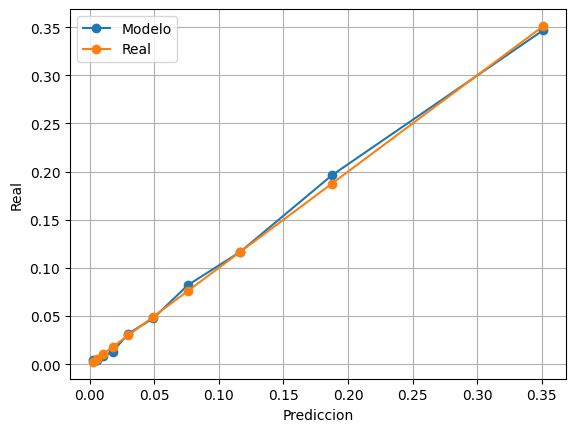

In [276]:
calibracion(probabilites_log_reg_random_feature_eng, y_test, 10)

(array([12500.,  3189.,  1756.,  1021.,   655.,   434.,   221.,   139.,
           59.,    26.]),
 array([2.93529084e-06, 6.84967120e-02, 1.36990489e-01, 2.05484265e-01,
        2.73978042e-01, 3.42471819e-01, 4.10965596e-01, 4.79459372e-01,
        5.47953149e-01, 6.16446926e-01, 6.84940702e-01]),
 <BarContainer object of 10 artists>)

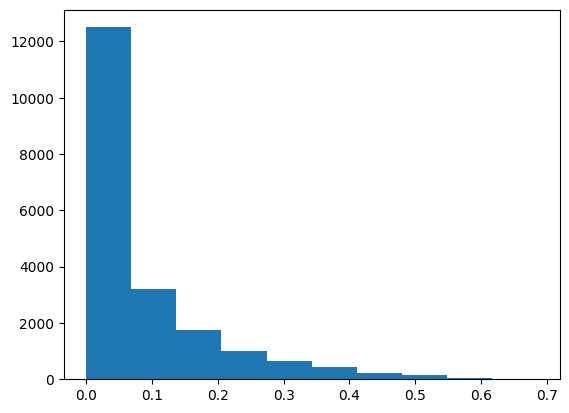

In [277]:
plt.hist(probabilites_log_reg_random_feature_eng, bins=10)

# Analisis del discriminante lineal feature eng

In [278]:
pipeline = Pipeline([
    ("scaler",  StandardScaler()),
    ("model", discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)

probabilidades_modelo_disc_fe = pipeline.predict_proba(X_test)[:, 1]
print("AUC", roc_auc_score(y_score=probabilidades_modelo_disc_fe, y_true=y_test))

AUC 0.837023818707811


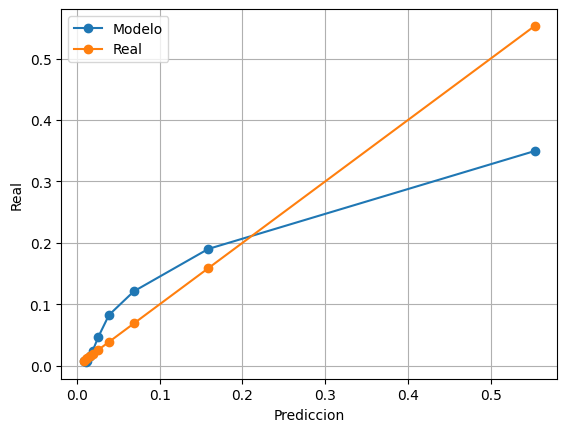

In [279]:
calibracion(probabilidades_modelo_disc_fe, y_test, 10)

(array([16163.,  1411.,   644.,   459.,   324.,   234.,   211.,   177.,
          177.,   200.]),
 array([0.0024664 , 0.1021891 , 0.20191179, 0.30163449, 0.40135719,
        0.50107988, 0.60080258, 0.70052528, 0.80024797, 0.89997067,
        0.99969337]),
 <BarContainer object of 10 artists>)

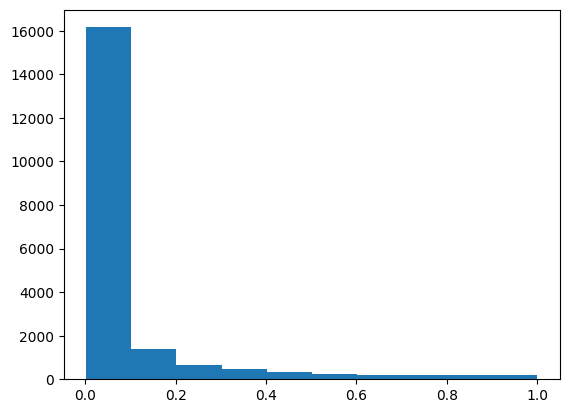

In [280]:
plt.hist(probabilidades_modelo_disc_fe, bins=10)

# Red Neuronal Feature Eng

In [281]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(max_iter=1000, random_state=42))
])

# Params grid
params_grid = {
     'nn__hidden_layer_sizes': [(50,50,50), (10,), (100,), (10,10)],
     'nn__activation': ['tanh', 'relu', 'logistic'],
     'nn__alpha': [0.1, 0.01]
}

# Fit 
grid_nn = RandomizedSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_distributions=params_grid)

grid_nn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('nn',
                                              MLPClassifier(max_iter=1000,
                                                            random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'nn__activation': ['tanh', 'relu',
                                                           'logistic'],
                                        'nn__alpha': [0.1, 0.01],
                                        'nn__hidden_layer_sizes': [(50, 50, 50),
                                                                   (10,),
                                                                   (100,),
                                                                   (10, 10)]},
                   scoring='roc_auc')

In [282]:
grid_nn.best_params_

{'nn__hidden_layer_sizes': (10,), 'nn__alpha': 0.1, 'nn__activation': 'tanh'}

In [283]:
nn_predictions_fe = grid_nn.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=nn_predictions_fe, y_true=y_test))

AUC 0.8391412086145934


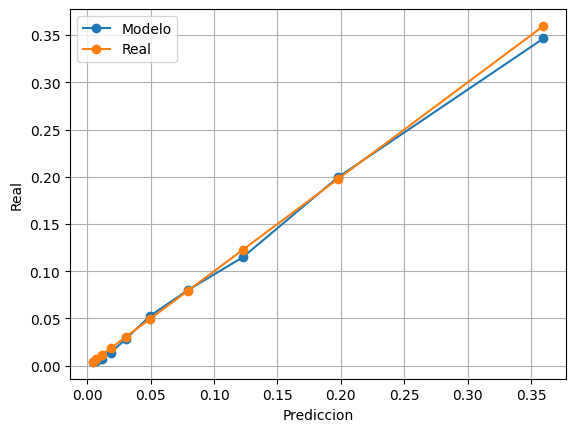

In [284]:
calibracion(nn_predictions_fe, y_test, 10)

(array([1.3001e+04, 3.0200e+03, 1.6290e+03, 1.0480e+03, 6.7400e+02,
        3.4900e+02, 1.7300e+02, 7.7000e+01, 2.3000e+01, 6.0000e+00]),
 array([0.00201596, 0.07807415, 0.15413234, 0.23019053, 0.30624872,
        0.38230691, 0.4583651 , 0.53442329, 0.61048148, 0.68653967,
        0.76259786]),
 <BarContainer object of 10 artists>)

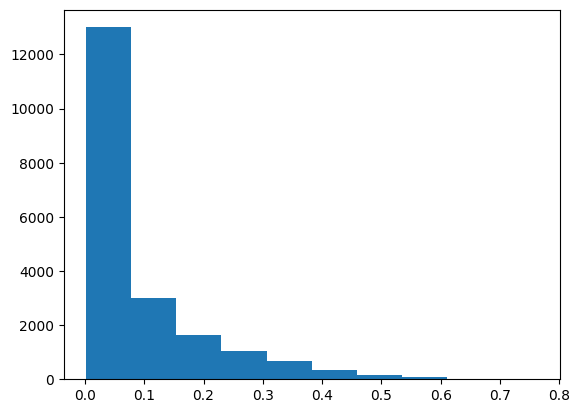

In [285]:
plt.hist(nn_predictions_fe, bins=10)

# AUC Modelos Feature Eng

In [286]:
auc = pd.DataFrame({
    'knn': [roc_auc_score(y_score=random_knn_fe, y_true=y_test)],
        'Regresion Logistica': [roc_auc_score(y_score=probabilites_log_reg_random_feature_eng, y_true=y_test)],
    'Analisis del discriminante lineal': [roc_auc_score(y_score=probabilidades_modelo_disc_fe, y_true=y_test)],
    'Red Neuronal': [roc_auc_score(y_score=nn_predictions_fe, y_true=y_test)]
})
auc

,knn,Regresion Logistica,Analisis del discriminante lineal,Red Neuronal
0,0.819733,0.839751,0.837024,0.839141


# Conclusiones